# 🧭 Project Title

## Zero-Trust Anomaly Detection in Authentication Logs

### 💡 Objective

Detect suspicious login behaviors (e.g., off-hours logins, impossible travel, unusual resource access) using a combination of unsupervised and semi-supervised ML models such as:

Isolation Forest

Autoencoder (deep learning)

One-Class SVM

In [1]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers, models

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("/Users/sheltonsimbi/projects/joan-testing/data/auth_logs_raw.csv")

df.head()

,timestamp,user_id,device_id,ip_address,location,login_success,access_time,resource_accessed,bytes_transferred,event_label
0,2025-11-10T12:04:55.770522,user_159,device_353,100.167.40.185,"New York, USA",1,12:04:55,sales,1.012750e+06,normal
1,2025-11-04T03:41:54.863533,user_442,device_48,47.240.52.239,"Cape Town, South Africa",0,03:41:54,prod,1.043741e+06,normal
2,2025-10-23T08:03:54.676219,user_271,device_269,194.182.164.123,"Cape Town, South Africa",1,08:03:54,hr,1.939472e+06,normal
3,2025-10-23T20:10:54.386531,user_140,device_109,94.225.238.58,"New York, USA",1,20:10:54,prod,5.380928e+05,normal
4,2025-11-10T01:12:53.942441,user_207,device_6,165.138.168.222,"Cape Town, South Africa",1,01:12:53,finance,1.332244e+06,off_hours_login


In [3]:
df['event_label'].unique()

array(['normal', 'off_hours_login', 'unusual_resource_access',
       'off_hours_login|unusual_resource_access', 'impossible_travel',
       'large_data_transfer|off_hours_login', 'multiple_failed_logins',
       'large_data_transfer',
       'impossible_travel|off_hours_login|unusual_resource_access',
       'impossible_travel|unusual_resource_access',
       'impossible_travel|off_hours_login',
       'large_data_transfer|unusual_resource_access',
       'large_data_transfer|off_hours_login|unusual_resource_access',
       'impossible_travel|multiple_failed_logins',
       'impossible_travel|large_data_transfer',
       'impossible_travel|large_data_transfer|unusual_resource_access',
       'impossible_travel|large_data_transfer|off_hours_login'],
      dtype=object)

In [4]:
# ------------------------------------------------------
# 🧠 Apply Zero-Trust Labeling
# ------------------------------------------------------
# In Zero-Trust, ONLY "normal" events are trusted.
# Everything else is treated as anomalous (1 = anomaly, 0 = normal)
ZERO_TRUST_NORMAL_LABEL = "normal"
zero_trust_anomaly_labels = sorted(
    label for label in df["event_label"].unique() if label != ZERO_TRUST_NORMAL_LABEL
)

df["binary_label"] = (df["event_label"] != ZERO_TRUST_NORMAL_LABEL).astype(int)

print("Zero-Trust anomaly labels:", zero_trust_anomaly_labels)
print(df["binary_label"].value_counts())
print("\n✅ Zero-Trust labels applied: 0 = Normal, 1 = Anomaly")


Zero-Trust anomaly labels: ['impossible_travel', 'impossible_travel|large_data_transfer', 'impossible_travel|large_data_transfer|off_hours_login', 'impossible_travel|large_data_transfer|unusual_resource_access', 'impossible_travel|multiple_failed_logins', 'impossible_travel|off_hours_login', 'impossible_travel|off_hours_login|unusual_resource_access', 'impossible_travel|unusual_resource_access', 'large_data_transfer', 'large_data_transfer|off_hours_login', 'large_data_transfer|off_hours_login|unusual_resource_access', 'large_data_transfer|unusual_resource_access', 'multiple_failed_logins', 'off_hours_login', 'off_hours_login|unusual_resource_access', 'unusual_resource_access']
binary_label
0    29759
1    20241
Name: count, dtype: int64

✅ Zero-Trust labels applied: 0 = Normal, 1 = Anomaly


In [5]:
# Cell 3: Quick overview
df.info()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          50000 non-null  object 
 1   user_id            50000 non-null  object 
 2   device_id          50000 non-null  object 
 3   ip_address         50000 non-null  object 
 4   location           50000 non-null  object 
 5   login_success      50000 non-null  int64  
 6   access_time        50000 non-null  object 
 7   resource_accessed  50000 non-null  object 
 8   bytes_transferred  50000 non-null  float64
 9   event_label        50000 non-null  object 
 10  binary_label       50000 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 4.2+ MB


,timestamp,user_id,device_id,ip_address,location,login_success,access_time,resource_accessed,bytes_transferred,event_label,binary_label
count,50000,50000,50000,50000,50000,50000.000000,50000,50000,5.000000e+04,50000,50000.000000
unique,50000,499,999,50000,10,NaN,37879,5,NaN,17,NaN
top,2025-11-10T12:04:55.770522,user_189,device_603,100.167.40.185,"Tokyo, Japan",NaN,16:28:58,prod,NaN,normal,NaN
freq,1,132,73,1,5087,NaN,6,14314,NaN,29759,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.843860,NaN,NaN,2.773499e+06,NaN,0.404820
std,NaN,NaN,NaN,NaN,NaN,0.362992,NaN,NaN,1.297885e+07,NaN,0.490862
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,6.250844e+04,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,8.135482e+05,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.216759e+06,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.843063e+06,NaN,1.000000


In [6]:
df['binary_label'].unique()

array([0, 1])

In [7]:
df.shape

(50000, 11)

# EDA

In [8]:
df.isna().sum()

timestamp            0
user_id              0
device_id            0
ip_address           0
location             0
login_success        0
access_time          0
resource_accessed    0
bytes_transferred    0
event_label          0
binary_label         0
dtype: int64

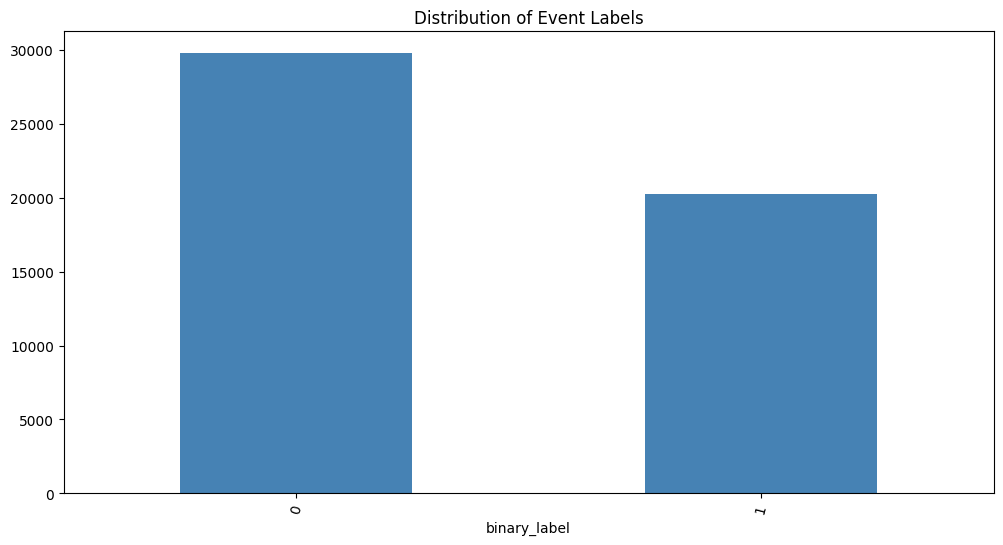

In [9]:
# Cell 5: Event label distribution
plt.figure(figsize=(12,6))
df['binary_label'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Distribution of Event Labels')
plt.xticks(rotation=75)
plt.show()


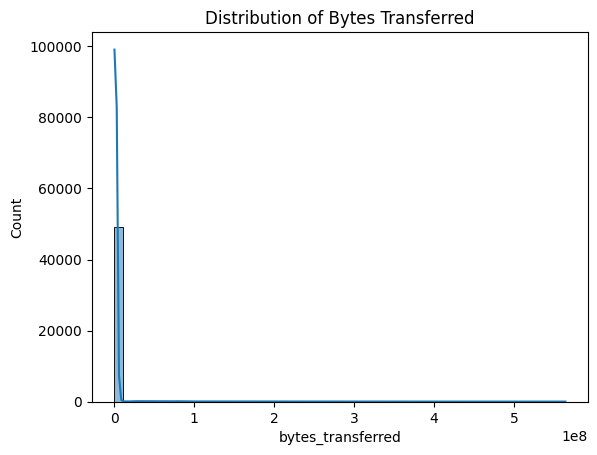

In [10]:
# Cell 6: Bytes transferred distribution
sns.histplot(df['bytes_transferred'], bins=50, kde=True)
plt.title('Distribution of Bytes Transferred')
plt.show()


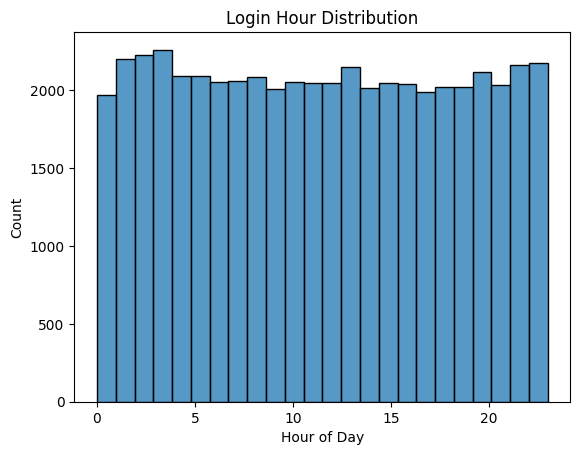

In [11]:
# Cell 7: Access time distribution
df['hour'] = pd.to_datetime(df['access_time'], format='%H:%M:%S').dt.hour
sns.histplot(df['hour'], bins=24, kde=False)
plt.title('Login Hour Distribution')
plt.xlabel('Hour of Day')
plt.show()


# ⚙️ 4. Feature Engineering

We’ll extract numeric and encoded features for modeling.

In [12]:
# Cell 8: Encode categorical columns
categorical_cols = ['user_id', 'device_id', 'ip_address', 'location', 'resource_accessed']
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])


In [13]:
# Cell 9: Convert event_label to binary (normal=0, anomaly=1)
df['is_anomaly'] = df['binary_label']


In [14]:
# Cell 10: Final feature matrix
features = ['user_id', 'device_id', 'ip_address', 'location', 
            'login_success', 'hour', 'resource_accessed', 'bytes_transferred']
X = df[features]
y = df['is_anomaly']


In [15]:
# Cell 11: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [16]:
# Cell 12: Split data (even though anomalies are rare)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

X_train_normal = X_train[y_train == 0]
expected_contamination = min(max(y_train.mean(), 1e-3), 0.49)


# 🧠 6. Model 1 — Isolation Forest

In [17]:
# Cell 13: Isolation Forest (Zero-Trust friendly)
iso = IsolationForest(contamination=expected_contamination, random_state=42)
iso.fit(X_train_normal)

y_pred_iso = iso.predict(X_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)  # Convert (-1 = anomaly) to (1)


Isolation Forest Results:
              precision    recall  f1-score   support

      normal       0.68      0.59      0.63      8928
     anomaly       0.50      0.59      0.54      6072

    accuracy                           0.59     15000
   macro avg       0.59      0.59      0.59     15000
weighted avg       0.61      0.59      0.60     15000



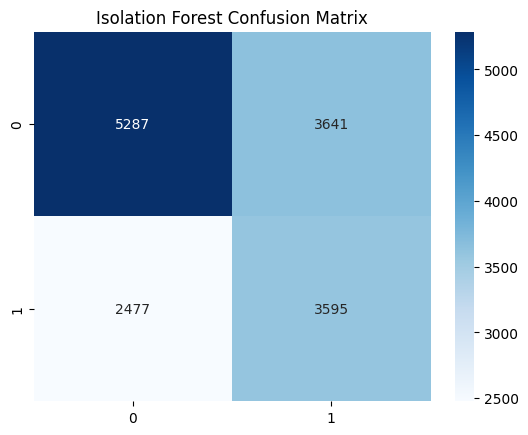

In [18]:
# Cell 14: Evaluation
print("Isolation Forest Results:")
print(classification_report(y_test, y_pred_iso, target_names=["normal", "anomaly"]))
sns.heatmap(confusion_matrix(y_test, y_pred_iso), annot=True, fmt='d', cmap='Blues')
plt.title("Isolation Forest Confusion Matrix")
plt.show()


# 🤖 7. Model 2 — One-Class SVM

One-Class SVM Results:
              precision    recall  f1-score   support

      normal       0.68      0.59      0.63      8928
     anomaly       0.50      0.59      0.54      6072

    accuracy                           0.59     15000
   macro avg       0.59      0.59      0.59     15000
weighted avg       0.61      0.59      0.59     15000



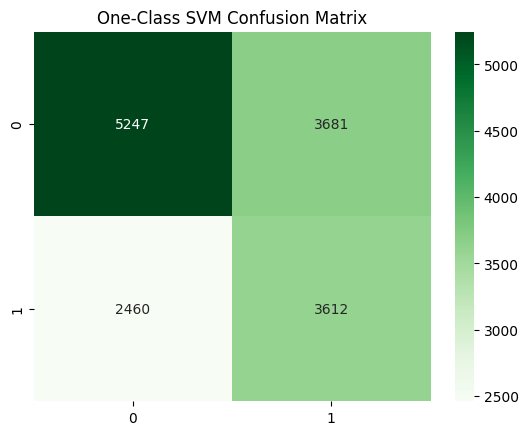

In [19]:
# Cell 15: One-Class SVM
svm_nu = min(max(expected_contamination, 0.01), 0.5)
svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=svm_nu)
svm.fit(X_train_normal)  # Train on normal data only

y_pred_svm = svm.predict(X_test)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

print("One-Class SVM Results:")
print(classification_report(y_test, y_pred_svm, target_names=["normal", "anomaly"]))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Greens')
plt.title("One-Class SVM Confusion Matrix")
plt.show()


# 🧬 8. Model 3 — Autoencoder (Deep Learning)

In [20]:
# Cell 16: Autoencoder
input_dim = X_train.shape[1]
encoding_dim = 4

autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(encoding_dim, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    X_train_normal,
    X_train_normal,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - loss: 0.6697 - val_loss: 0.4479
Epoch 2/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 0.3624 - val_loss: 0.3261
Epoch 3/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 0.3038 - val_loss: 0.2690
Epoch 4/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 0.2562 - val_loss: 0.2400
Epoch 5/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 0.2368 - val_loss: 0.2255
Epoch 6/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 0.2266 - val_loss: 0.2178
Epoch 7/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 0.2202 - val_loss: 0.2130
Epoch 8/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 0.2158 - val_loss: 0.2091
Epoch 9/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 0.2118 - val_loss: 0.2051
Epoch 10/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 0.2089 - val_loss: 0.2031
Epoch 11/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 0.2062 - val_loss: 0.2013
Epoch 12/20
586/586 ━━━━━━━━━━

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
Autoencoder Results:
              precision    recall  f1-score   support

      normal       0.62      0.98      0.76      8928
     anomaly       0.81      0.10      0.18      6072

    accuracy                           0.63     15000
   macro avg       0.71      0.54      0.47     15000
weighted avg       0.69      0.63      0.52     15000



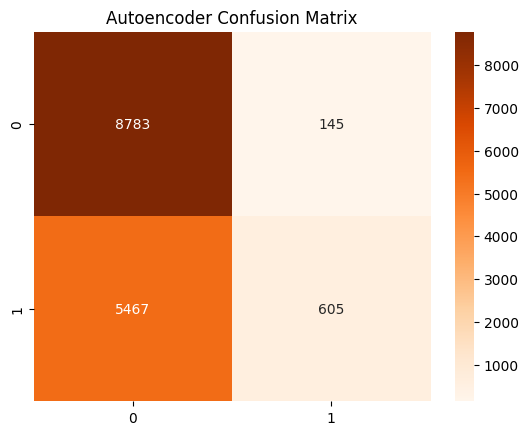

In [21]:
# Cell 17: Reconstruction error and threshold
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)

y_pred_auto = np.where(mse > threshold, 1, 0)

print("Autoencoder Results:")
print(classification_report(y_test, y_pred_auto, target_names=["normal", "anomaly"]))
sns.heatmap(confusion_matrix(y_test, y_pred_auto), annot=True, fmt='d', cmap='Oranges')
plt.title("Autoencoder Confusion Matrix")
plt.show()


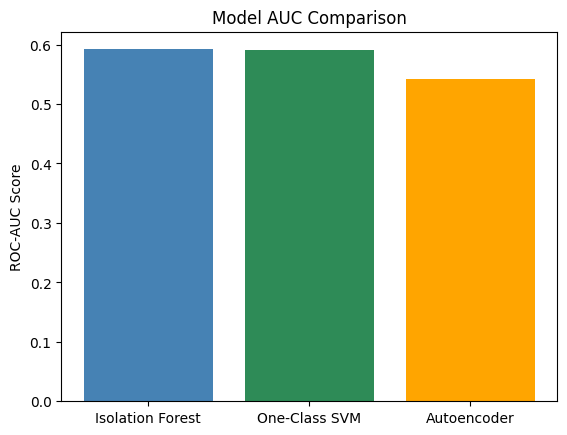

In [22]:
# Cell 18: Compare models
models = ['Isolation Forest', 'One-Class SVM', 'Autoencoder']
aucs = [
    roc_auc_score(y_test, y_pred_iso),
    roc_auc_score(y_test, y_pred_svm),
    roc_auc_score(y_test, y_pred_auto)
]

plt.bar(models, aucs, color=['steelblue','seagreen','orange'])
plt.title("Model AUC Comparison")
plt.ylabel("ROC-AUC Score")
plt.show()


# 🧩 19. Fine-Tuning Hyperparameters

We’ll perform grid-search-style tuning for contamination, nu, and the Autoencoder’s threshold percentile.

In [23]:
# Cell 19: Fine-tuning IsolationForest, OneClassSVM, and Autoencoder threshold

from sklearn.metrics import f1_score

def evaluate_models(contamination_vals, nu_vals, threshold_percents):
    best_results = {}

    for c in contamination_vals:
        iso = IsolationForest(contamination=c, random_state=42)
        iso.fit(X_train_normal)
        preds = np.where(iso.predict(X_test) == -1, 1, 0)
        f1 = f1_score(y_test, preds)
        best_results[f"IsolationForest_c={c}"] = f1

    for n in nu_vals:
        svm = OneClassSVM(kernel='rbf', gamma='scale', nu=n)
        svm.fit(X_train_normal)
        preds = np.where(svm.predict(X_test) == -1, 1, 0)
        f1 = f1_score(y_test, preds)
        best_results[f"OneClassSVM_nu={n}"] = f1

    recon = autoencoder.predict(X_test)
    mse = np.mean(np.power(X_test - recon, 2), axis=1)
    for t in threshold_percents:
        threshold = np.percentile(mse, t)
        preds = np.where(mse > threshold, 1, 0)
        f1 = f1_score(y_test, preds)
        best_results[f"Autoencoder_thr={t}"] = f1

    return pd.DataFrame(list(best_results.items()), columns=["Model_Param", "F1_Score"]).sort_values("F1_Score", ascending=False)

tune_results = evaluate_models(
    contamination_vals=[0.02, 0.05, 0.1],
    nu_vals=[0.01, 0.05, 0.1],
    threshold_percents=[90, 95, 99]
)

tune_results


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step


,Model_Param,F1_Score
5,OneClassSVM_nu=0.1,0.457704
4,OneClassSVM_nu=0.05,0.387968
6,Autoencoder_thr=90,0.297147
3,OneClassSVM_nu=0.01,0.251982
2,IsolationForest_c=0.1,0.186504
7,Autoencoder_thr=95,0.177367
1,IsolationForest_c=0.05,0.111608
0,IsolationForest_c=0.02,0.055779
8,Autoencoder_thr=99,0.048216


# 🔍 20. SHAP-based Feature Importance (Isolation Forest)

This helps visualize which features drive anomaly decisions.

In [24]:
# --- Recreate trained Isolation Forest model ---
from sklearn.ensemble import IsolationForest

iso_final = IsolationForest(contamination=expected_contamination, random_state=42)
iso_final.fit(X_train_normal)


,n_estimators,100
,max_samples,'auto'
,contamination,0.4048285714285714
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/500 [00:00<?, ?it/s]

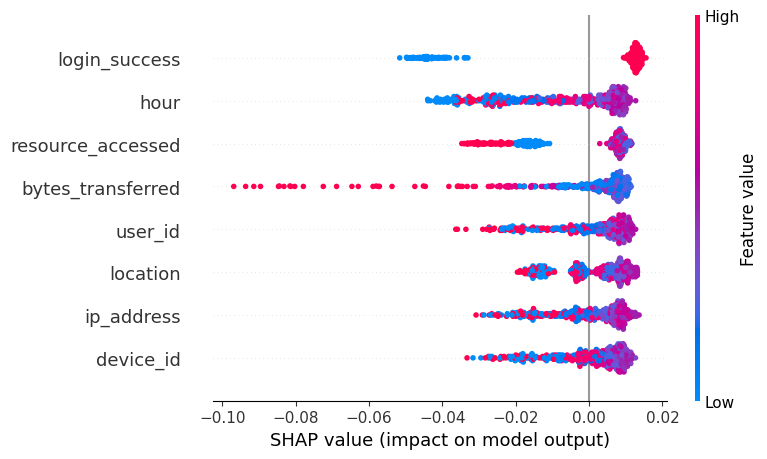

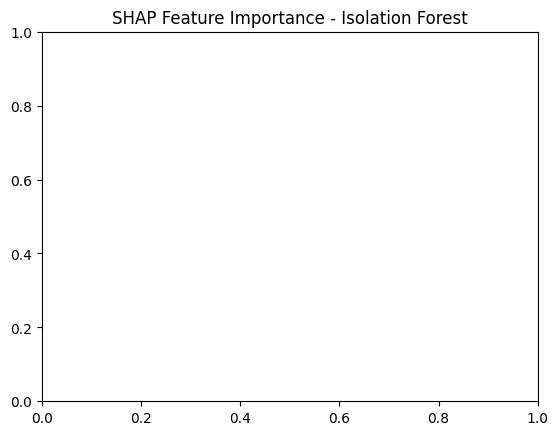

In [25]:
# --- SHAP Feature Importance for Isolation Forest ---
import shap
import matplotlib.pyplot as plt

# Build explainer on your trained model using anomaly scores
sample_size = min(500, len(X_train_normal))
background = X_train_normal[:sample_size]

explainer = shap.KernelExplainer(iso_final.decision_function, background)
shap_values = explainer.shap_values(X_test[:sample_size])
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Summarize feature importance
shap.summary_plot(shap_values, X_test[:sample_size], feature_names=features)
plt.title("SHAP Feature Importance - Isolation Forest")
plt.show()


# ⚙️ 21. REST API Deployment with FastAPI + Kafka (Simulation)

Below is a lightweight FastAPI service that exposes /predict for real-time anomaly scoring.

In [26]:
# Cell 21: FastAPI REST endpoint (run separately with uvicorn)

from fastapi import FastAPI
import joblib
import numpy as np

app = FastAPI(title="Zero-Trust Anomaly Detector")

# save models
joblib.dump(iso_final, "isoforest_model.pkl")
joblib.dump(scaler, "scaler.pkl")

@app.post("/predict")
def predict(data: dict):
    x = np.array(data["features"]).reshape(1, -1)
    x_scaled = joblib.load("scaler.pkl").transform(x)
    pred = joblib.load("isoforest_model.pkl").predict(x_scaled)
    result = "anomaly" if pred[0] == -1 else "normal"
    return {"prediction": result}



# 📊 23. Zero-Trust Dashboard (Streamlit)

This adds an interactive monitoring dashboard.

Create a new file dashboard/app.py:

In [27]:
# Cell 23 (dashboard/app.py)
import streamlit as st
import pandas as pd
import joblib
import numpy as np

st.title("🔒 Zero-Trust Anomaly Detection Dashboard")

iso_model = joblib.load("isoforest_model.pkl")
scaler = joblib.load("scaler.pkl")

uploaded = st.file_uploader("Upload authentication logs (CSV)", type=["csv"])

if uploaded:
    df = pd.read_csv(uploaded)
    X = scaler.transform(df[features])
    preds = np.where(iso_model.predict(X) == -1, "Anomaly", "Normal")
    df["Prediction"] = preds
    st.dataframe(df)
    st.bar_chart(df["Prediction"].value_counts())


2025-11-11 23:14:23.594 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 23:14:23.823 
  command:

    streamlit run /opt/anaconda3/envs/llms/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-11-11 23:14:23.823 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 23:14:23.824 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 23:14:23.835 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 23:14:23.836 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 23:14:23.836 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 23:14:23.836 Thread 'Main

# 🕒 24. Temporal Sequence Behavior (User Baseline)

We’ll add a user-based average activity tracker to identify deviations.

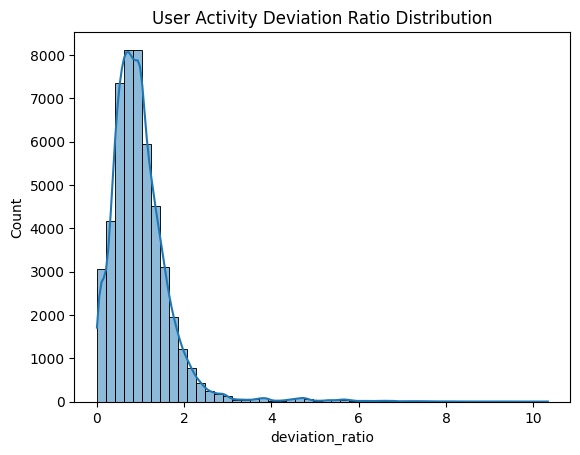

In [28]:
# Cell 24: Temporal baseline modeling
df['timestamp'] = pd.to_datetime(df['timestamp'])
user_hour_mean = df.groupby(['user_id', 'hour'])['bytes_transferred'].mean().reset_index()
user_hour_mean.rename(columns={'bytes_transferred':'mean_bytes'}, inplace=True)

# Merge baseline back
df = df.merge(user_hour_mean, on=['user_id','hour'], how='left')
df['deviation_ratio'] = (df['bytes_transferred'] / (df['mean_bytes']+1e-5))

sns.histplot(df['deviation_ratio'], bins=50, kde=True)
plt.title("User Activity Deviation Ratio Distribution")
plt.show()


In [ ]:
# To run the API:
# uvicorn anomaly_api:app --host 0.0.0.0 --port 8000
# M:246.U8g6x9-6K
